# Database Walkthrough

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn; seaborn.set_theme()
import plotly.io; plotly.io.templates.default = "seaborn"
import emat
import yaml
from emat.util.show_dir import show_dir
from emat.analysis import display_experiments
emat.versions()

emat 0.6.4, plotly 5.24.1


For this walkthrough of database features, we'll work in a temporary directory. 
(In real projects you'll likely want to save your data somewhere less ephemeral,
so don't just copy this tempfile code into your work.)

In [2]:
import tempfile
tempdir = tempfile.TemporaryDirectory()
os.chdir(tempdir.name)

We begin our example by populating a database with some experimental data, by creating and
running a single design of experiments for the Road Test model.

In [3]:
import emat.examples
scope, db, model = emat.examples.road_test()
design = model.design_experiments()
model.run_experiments(design);

## Single-Design Datasets

### Writing Out Raw Data

When the database has only a single design of experiments, or if we
don't care about any differentiation between multiple designs that we
may have created and ran, we can dump the entire set of model runs,
including uncertainties, policy levers, and performance measures, all
consolidated into a single pandas DataFrame using the 
`read_experiment_all` function.  The constants even appear in this DataFrame
too, for good measure.

In [4]:
df = db.read_experiment_all(scope.name)
df

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,83.038716,69.586789,13.451927,92.059972,-22.290905,114.350877,2154.415985
2,60,100,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,88.474313,62.132583,26.341730,366.219659,-16.843014,383.062672,12369.380535
3,60,100,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,75.027180,62.543328,12.483852,53.584943,-113.988412,167.573355,4468.506839
4,60,100,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,77.370428,62.268768,15.101660,311.462907,11.539561,299.923347,6526.325171
5,60,100,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,88.328990,72.848428,15.480561,138.156464,78.036616,60.119848,2460.910705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,60,100,0.169674,4.939898,150,0.131775,112.348054,0.033034,-0.000120,24.215074,34,Rev Bond,True,135.446332,85.847986,49.598345,980.371960,841.462782,138.909178,2720.516457
107,60,100,0.148297,3.824779,110,0.103255,105.248708,0.033437,0.007041,38.013885,22,GO Bond,True,72.811506,63.736168,9.075338,103.078214,-146.712793,249.791007,4000.912327
108,60,100,0.134701,3.627795,144,0.035233,132.063099,0.036702,0.018681,52.155613,32,Paygo,True,90.340993,66.617994,23.722999,120.358653,-112.568104,232.926757,6887.831931


Exporting this data is simply a matter of using the usual pandas 
methods to save the dataframe to a format of your choosing.  We'll
save our data into a gzipped CSV file, which is somewhat compressed
(we're not monsters here) but still widely compatible for a variety of uses.

In [5]:
df.to_csv("road_test_1.csv.gz")

This table contains most of the information we want to export from
our database, but not everything.  We also probably want to have access
to all of the information in the exploratory scope as well.  Our example
generator gives us a `Scope` reference directly, but if we didn't have that
we can still extract it from the database, using the `read_scope` method.

In [6]:
s = db.read_scope()
s

<emat.Scope with 2 constants, 7 uncertainties, 4 levers, 7 measures>

In [7]:
s.dump(filename="road_test_scope.yaml")

In [8]:
show_dir('.')

/
├── road_test_1.csv.gz
└── road_test_scope.yaml


### Reading In Raw Data

Now, we're ready to begin anew, constructing a fresh database from scratch,
using only the raw formatted files.

First, let's load our scope from the yaml file, and initialize a clean database
using that scope.

In [9]:
s2 = emat.Scope("road_test_scope.yaml")

In [10]:
db2 = emat.SQLiteDB("road_test_2.sqldb")

In [11]:
db2.store_scope(s2)

Just as we used pandas to save out our consolidated DataFrame of experimental results,
we can use it to read in a consolidated table of experiments.

In [12]:
df2 = pd.read_csv("road_test_1.csv.gz", index_col='experiment')
df2

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,83.038716,69.586789,13.451927,92.059972,-22.290905,114.350877,2154.415985
2,60,100,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,88.474313,62.132583,26.341730,366.219659,-16.843014,383.062672,12369.380535
3,60,100,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,75.027180,62.543328,12.483852,53.584943,-113.988412,167.573355,4468.506839
4,60,100,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,77.370428,62.268768,15.101660,311.462907,11.539561,299.923347,6526.325171
5,60,100,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,88.328990,72.848428,15.480561,138.156464,78.036616,60.119848,2460.910705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,60,100,0.169674,4.939898,150,0.131775,112.348054,0.033034,-0.000120,24.215074,34,Rev Bond,True,135.446332,85.847986,49.598345,980.371960,841.462782,138.909178,2720.516457
107,60,100,0.148297,3.824779,110,0.103255,105.248708,0.033437,0.007041,38.013885,22,GO Bond,True,72.811506,63.736168,9.075338,103.078214,-146.712793,249.791007,4000.912327
108,60,100,0.134701,3.627795,144,0.035233,132.063099,0.036702,0.018681,52.155613,32,Paygo,True,90.340993,66.617994,23.722999,120.358653,-112.568104,232.926757,6887.831931


Writing experiments to a database is not quite as simple as reading them.  There
is a parallel `write_experiment_all` method for the `Database` class, but to use 
it we need to provide not only the DataFrame of actual results, but also a name for
the design of experiments we are writing (all experiments exist within designs) and
the source of the performance measure results (zero means actual results from a 
core model run, and non-zero values are ID numbers for metamodels). This allows many
different possible sets of performance measures to be stored for the same set
of input parameters.

In [13]:
db2.write_experiment_all(
    scope_name=s2.name, 
    design_name='general',
    source=0,
    xlm_df=df2,
)

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



Time Savings

<xmle.Elem 'img' with 0 children>
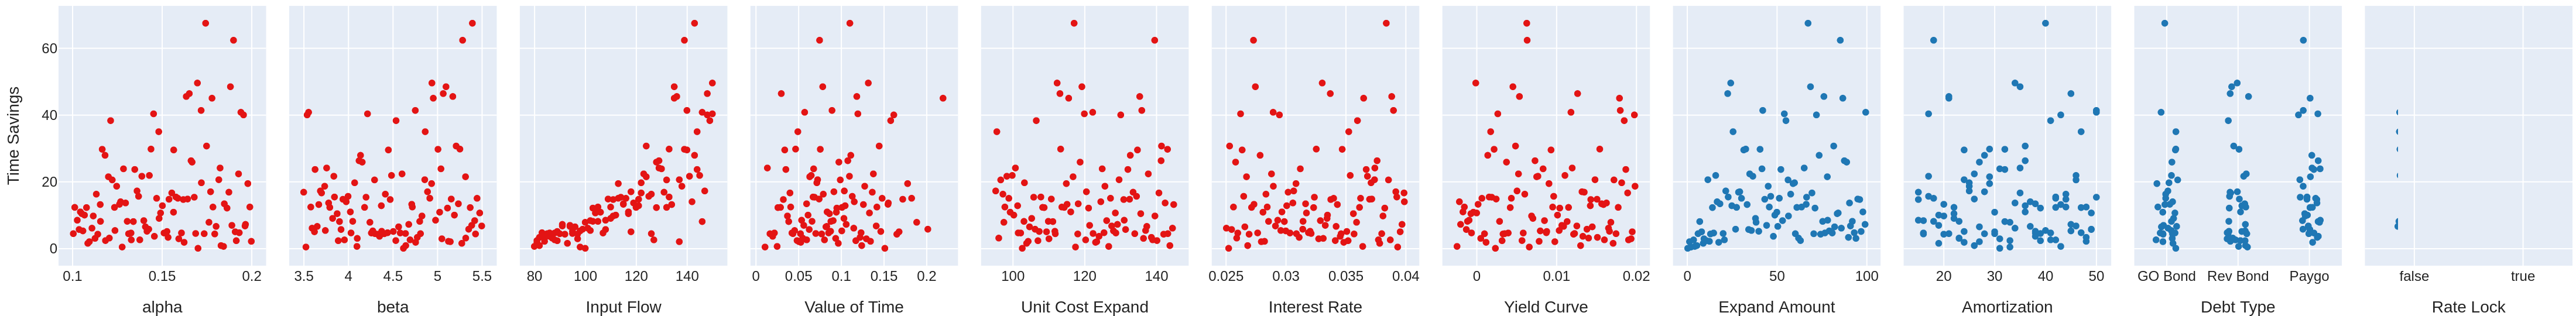

In [14]:
display_experiments(s2, 'general', db=db2, rows=['time_savings'])

## Multiple-Design Datasets

The EMAT database is not limited to storing a single design of experiments.  Multiple designs 
can be stored for the same scope.  We'll add a set of univariate sensitivity test to our
database, and a "ref" design that contains a single experiment with all inputs set to their
default values.

In [15]:
design_uni = model.design_experiments(sampler='uni')
model.run_experiments(design_uni)
model.run_reference_experiment();

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



We now have three designs stored in our database. We can confirm this
by reading out the set of design names.

In [16]:
db.read_design_names(s.name)

['lhs', 'ref', 'uni']

The design names we se here are the default names given when designs are created with each of the given samplers.  When creating new designs, we can override the default names with other names of our choice using the `design_name` argument.  The names can be any string not already in use.

In [17]:
design_b = model.design_experiments(sampler='lhs', design_name='bruce')
db.read_design_names(s.name)

['bruce', 'lhs', 'ref', 'uni']

If you try to re-use a name you'll get an error, as having multiple designs with the same name does not allow you to make it clear which design you are referring to.

In [18]:
try:
    model.design_experiments(sampler='lhs', design_name='bruce')
except ValueError as err:
    print(err)

the design "bruce" already exists for domain "EMAT Road Test"


As noted above, the design name, which can be any string, is separate from the sampler method. A default design name based on the name of the sampler method is used if no design name is given.  The selected sampler must be one available in EMAT, as the sampler defines a particular logic about how to generate the design.

In [19]:
try:
    model.design_experiments(sampler='uni')
except ValueError as err:
    print(err)

Note that there 
can be some experiments that are in more than one design.  This is
not merely duplicating the experiment and results, but actually 
assigning the same experiment to both designs.  We can see this
for the 'uni' and 'ref' designs -- both contain the all-default 
parameters experiment, and when we read these designs out of the 
database, the same experiment number is reported out in both 
designs.

In [20]:
db.read_experiment_all(scope.name, design_name='uni').head()

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
111,60,100,0.15,4.0,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,69.0,66.147121,2.852879,21.396592,-30.807346,52.203937,1000.0
112,60,100,0.10,4.0,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,66.0,64.098081,1.901919,14.264395,-37.939543,52.203937,1000.0
113,60,100,0.20,4.0,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,72.0,68.196161,3.803839,28.528789,-23.675148,52.203937,1000.0
114,60,100,0.15,3.5,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,69.0,66.447155,2.552845,19.146338,-33.057600,52.203937,1000.0
115,60,100,0.15,5.5,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,69.0,65.328227,3.671773,27.538295,-24.665642,52.203937,1000.0


In [21]:
db.read_experiment_all(scope.name, design_name='ref')

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
111,60,100,0.15,4.0,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,69.0,66.147121,2.852879,21.396592,-30.807346,52.203937,1000.0


One "gotcha" to be wary of is unintentionally replicating experiments.  By default, the `random_seed` for randomly generated experiemnts is set to 0 for reproducibility.  This means that, for example, the 'bruce' design is actually the same as the original 'lhs' design:

In [22]:
db.read_experiment_all(scope.name, design_name='lhs').equals(
    db.read_experiment_all(scope.name, design_name='bruce')
)

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



True

If we want a new set of random experiments with the same sampler and other parameters, we'll need to provide a different `random_seed`.

In [23]:
design_b = model.design_experiments(sampler='lhs', design_name='new_bruce', random_seed=42)
db.read_experiment_all(scope.name, design_name='lhs').equals(design_b)

False

### Writing Out Raw Data

We can read a single dataframe containing all the experiments associated with
this scope by omitting the `design_name` argument, just as if there was only
one design.

In [24]:
df = db.read_experiment_all(scope.name)
df

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,83.038716,69.586789,13.451927,92.059972,-22.290905,114.350877,2154.415985
2,60,100,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,88.474313,62.132583,26.341730,366.219659,-16.843014,383.062672,12369.380535
3,60,100,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,75.027180,62.543328,12.483852,53.584943,-113.988412,167.573355,4468.506839
4,60,100,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,77.370428,62.268768,15.101660,311.462907,11.539561,299.923347,6526.325171
5,60,100,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,88.328990,72.848428,15.480561,138.156464,78.036616,60.119848,2460.910705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,60,100,0.164649,4.851786,104,0.012456,127.667298,0.025673,0.012674,24.114264,30,GO Bond,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,60,100,0.113568,4.545709,105,0.137105,139.911784,0.028280,0.016936,92.883345,15,GO Bond,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,60,100,0.184434,4.732430,144,0.100242,99.904559,0.030392,0.019534,84.793007,15,GO Bond,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This dataframe is different than the one we saw earlier with the same command, as we have since added a few more experiments to the database in a few different designs.  If we don't give a `design_name` argument, we'll retrieve every (unique) experiment from every design currently stored in the database.  

In [25]:
df.to_csv("road_test_2.csv.gz")

If we want to be able to reconstruct the various designs of experiments later, 
we'll also need to write out instructions for that.  The `read_all_experiment_ids`
method can give us a dictionary of all the relevant information.

In [26]:
design_experiments = db.read_all_experiment_ids(scope.name, design_name='*',grouped=True)
design_experiments

{'bruce': '1-110',
 'lhs': '1-110',
 'new_bruce': '133-242',
 'ref': '111',
 'uni': '111-132',
 'uni_2': '111-132'}

We can write this dictionary to a file in 'yaml' format.

In [27]:
with open("road_test_design_experiments.yaml", 'wt') as f:
    yaml.dump(design_experiments, f)

### Reading In Raw Data

To construct a new emat Database with multiple designs of experients,...

In [28]:
db3 = emat.SQLiteDB("road_test_3.sqldb")
db3.store_scope(s2)

In [29]:
df3 = pd.read_csv("road_test_2.csv.gz", index_col='experiment')
df3

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.059510,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,83.038716,69.586789,13.451927,92.059972,-22.290905,114.350877,2154.415985
2,60,100,0.166133,4.121963,129,0.107772,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,88.474313,62.132583,26.341730,366.219659,-16.843014,383.062672,12369.380535
3,60,100,0.198937,4.719838,105,0.040879,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,75.027180,62.543328,12.483852,53.584943,-113.988412,167.573355,4468.506839
4,60,100,0.158758,4.915816,113,0.182517,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,77.370428,62.268768,15.101660,311.462907,11.539561,299.923347,6526.325171
5,60,100,0.157671,3.845952,133,0.067102,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,88.328990,72.848428,15.480561,138.156464,78.036616,60.119848,2460.910705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,60,100,0.164649,4.851786,104,0.012456,127.667298,0.025673,0.012674,24.114264,30,GO Bond,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,60,100,0.113568,4.545709,105,0.137105,139.911784,0.028280,0.016936,92.883345,15,GO Bond,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,60,100,0.184434,4.732430,144,0.100242,99.904559,0.030392,0.019534,84.793007,15,GO Bond,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
with open("road_test_design_experiments.yaml", 'rt') as f:
    design_experiments2 = yaml.safe_load(f)
design_experiments2

{'bruce': '1-110',
 'lhs': '1-110',
 'new_bruce': '133-242',
 'ref': '111',
 'uni': '111-132',
 'uni_2': '111-132'}

In [31]:
db3.write_experiment_all(
    scope_name=s2.name, 
    design_name=design_experiments2,
    source=0,
    xlm_df=df3,
)

In [32]:
db3.read_design_names(s.name)

['bruce', 'lhs', 'new_bruce', 'ref', 'uni', 'uni_2']

In [33]:
db3.read_all_experiment_ids(scope.name, design_name='*',grouped=True)

{'bruce': '1-110',
 'lhs': '1-110',
 'new_bruce': '133-242',
 'ref': '111',
 'uni': '111-132',
 'uni_2': '111-132'}

In [34]:
db3.read_experiment_all(scope.name, design_name='uni').head()

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
111,60,100,0.15,4.0,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,69.0,66.147121,2.852879,21.396592,-30.807346,52.203937,1000.0
112,60,100,0.10,4.0,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,66.0,64.098081,1.901919,14.264395,-37.939543,52.203937,1000.0
113,60,100,0.20,4.0,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,72.0,68.196161,3.803839,28.528789,-23.675148,52.203937,1000.0
114,60,100,0.15,3.5,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,69.0,66.447155,2.552845,19.146338,-33.057600,52.203937,1000.0
115,60,100,0.15,5.5,100,0.075,100.0,0.03,0.01,10.0,30,GO Bond,False,69.0,65.328227,3.671773,27.538295,-24.665642,52.203937,1000.0


## Re-running Experiments

This section provides a short walkthrough of how to handle mistakes 
in an EMAT database.  By "mistakes" we are referring to incorrect
values that have been written into the database by accident, generally 
arising from core model runs that were misconfigured or suffered 
non-fatal errors that caused the results to be invalid.

One approach to handling such problems is to simply start over with a
brand new clean database file.  However, this may be inconvenient if
the database already includes a number of valid results, especially if
those valid results were expensive to generate.  It may also be desirable
to keep prior invalid results on hand, so as to easily recognized when
errors recur.

We begin this example by populating our database with some more experimental data, by creating and
running a single design of experiments for the Road Test model, except these experiments will be
created with a misconfigured model (lane_width = 11, it should be 10), so the results will be bad.
(In general, you probably won't intentionally create corrupt data, but we're doing so here for 
expository purposes, so we'll give this design a name of 'oops' so we can readily recall what we've done.)

In [35]:
model.lane_width = 10.3
oops = model.design_experiments(design_name='oops', random_seed=12345)
model.run_experiments(oops);

We can review a dataframe of results as before, using the `read_experiment_all`
method. This time we will add `with_run_ids=True`, which will add an extra
column to the index, showing a universally unique id attached to each row
of results.

In [36]:
oops_result1 = db.read_experiment_all(scope.name, 'oops', with_run_ids=True)
oops_result1.head()

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



,,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,run,,,,,,,,,,,,,,,,,,,,
243,49a3688e-c4ba-11ef-bee1-999d69bac96a,60,100,0.157955,4.270404,112,0.151487,116.445987,0.029784,0.018968,50.163393,38,Rev Bond,False,75.376818,79.495869,-4.119051,-69.886026,-381.303111,311.417085,5841.325841
244,49a3688f-c4ba-11ef-bee1-999d69bac96a,60,100,0.165144,4.008218,134,0.039670,102.879244,0.032505,0.000708,57.330143,40,Rev Bond,False,92.024075,83.059349,8.964726,47.654780,-220.075486,267.730266,5898.081794
245,49a36890-c4ba-11ef-bee1-999d69bac96a,60,100,0.103964,4.019636,92,0.100936,131.282035,0.038432,0.002658,64.949710,39,GO Bond,True,64.461446,77.449591,-12.988145,-120.608948,-520.723349,400.114402,8526.730135
246,49a36891-c4ba-11ef-bee1-999d69bac96a,60,100,0.172162,4.920619,144,0.135484,95.348634,0.025803,0.008870,77.498534,26,Paygo,False,122.134147,80.716842,41.417305,808.041389,513.014691,295.026699,7389.379292
247,49a36892-c4ba-11ef-bee1-999d69bac96a,60,100,0.136954,4.901048,100,0.109919,114.310247,0.027538,0.016733,46.312847,41,Paygo,False,68.217253,78.289223,-10.071970,-110.710261,-276.303370,165.593109,5294.033017


Time Savings

<xmle.Elem 'img' with 0 children>
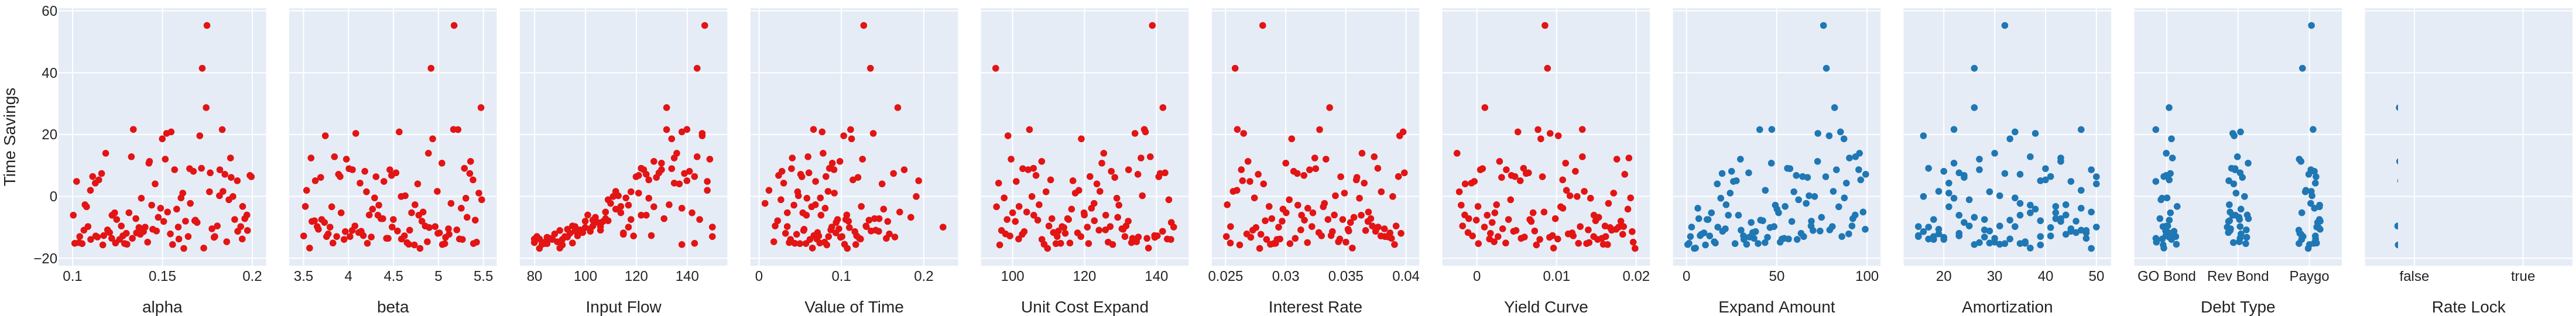

In [37]:
display_experiments(scope, oops_result1, rows=['time_savings'])

Some of these results are obviously problematic.  Increasing capacity cannot possibly
result in a negative travel time savings. (Braess paradox doesn't apply here because 
it's just one link, not a network.)  So those negative values are clearly wrong.  We 
can fix the model so they won't be wrong, but by default the `run_experiments` method
won't actually re-run models when the results are already available in the database.
To solve this conundrum, we can mark the incorrect results as invalid, using a query
to pull out the rows that can be flagged as wrong.

In [38]:
db.invalidate_experiment_runs(
    queries=['time_savings < 0']
)

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



[73]

The `[73]` returned here indicates that 73 sets of results were invalidated by this command.
The invalidation command actually sets a "valid" flag in the database to False for these
experiment runs, so that a persistant record that they are bad is stored in the database.
Now we can fix our model, and then use the `run_experiments` method to get new model runs for
the invalidated results.

In [39]:
model.lane_width = 10
oops_result2 = model.run_experiments(oops)

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all 

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all 

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



Time Savings

<xmle.Elem 'img' with 0 children>
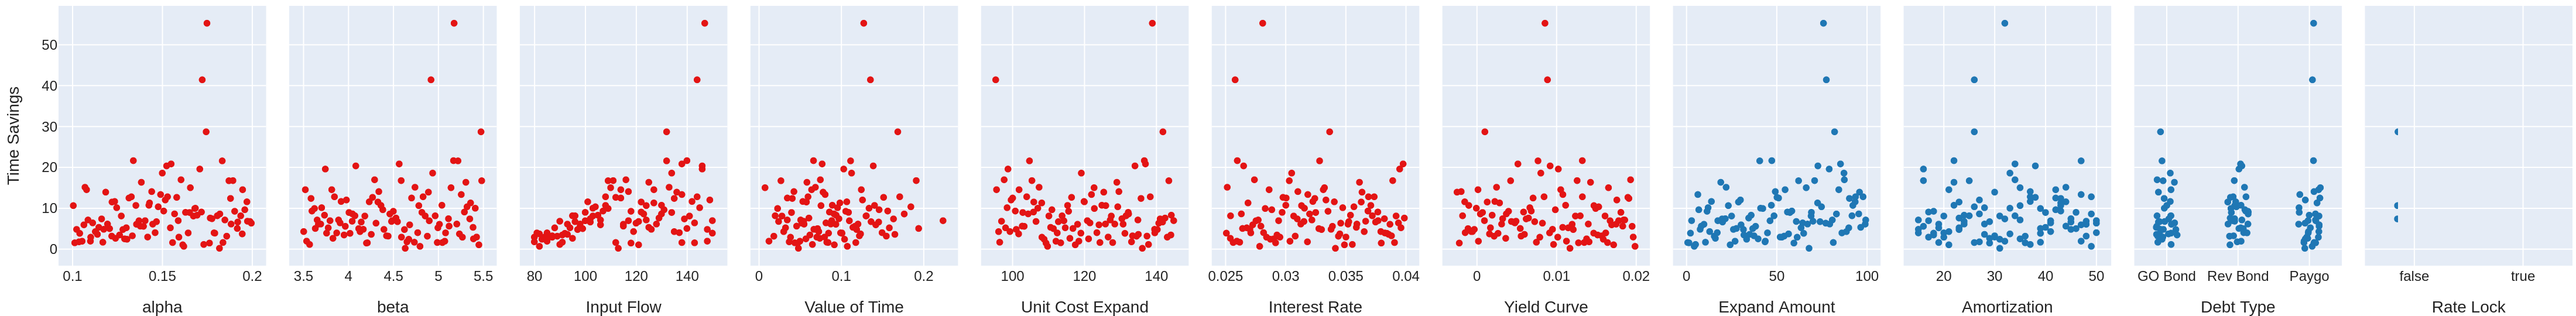

In [40]:
display_experiments(scope, 'oops', db=db, rows=['time_savings'])

The re-run fixed the negative values, although it left in place the other 
experimental runs in the database. By the way we constructed this example, 
we know those are wrong too, and it's evident in the apparent discontinuity
in the input flow graph, which we can zoom in on.

/home/runner/work/tmip-emat/tmip-emat/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



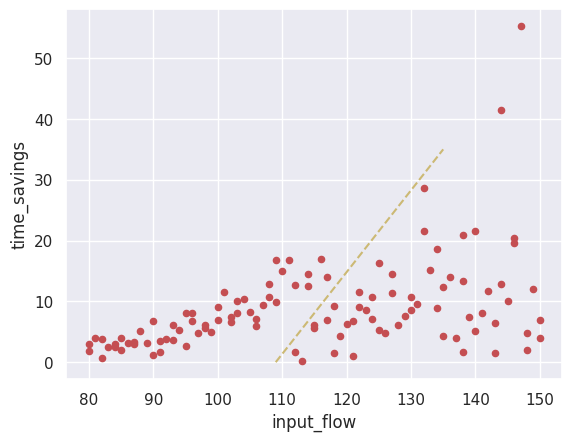

In [41]:
ax = oops_result2.plot.scatter(x='input_flow', y='time_savings', color='r')
ax.plot([109,135], [0,35], '--',color='y');

Those original results are bad too, and we want to invalidate them as well.
In addition to giving conditional queries to the `invalidate_experiment_runs`
method, we can also give a dataframe of results that have run ids attached, 
and those unique ids will be used to to find and invalidate results in the 
database.  Here, we pass in the dataframe of all the results, which contains
all 110 runs, but only 37 runs are newly invalidated (77 were invalidated 
previously).

In [42]:
db.invalidate_experiment_runs(
    oops_result1
)

37

Now when we run the experiments again, those 37 experiments are re-run.

In [43]:
oops_result3 = model.run_experiments(oops)

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all 

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all 

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



Time Savings

<xmle.Elem 'img' with 0 children>
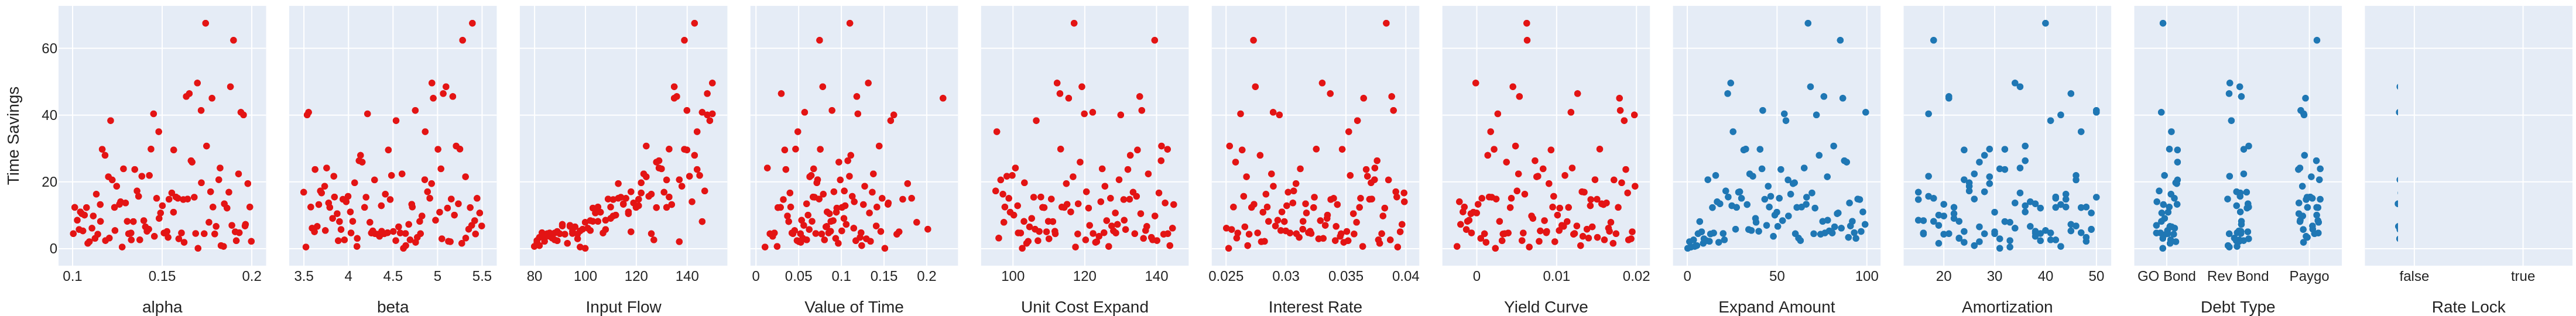

In [44]:
display_experiments(scope, 'lhs', db=db, rows=['time_savings'])

### Writing Out All Runs

By default, the `read_experiment_all` method returns the most recent valid set of 
performance measures for each experiment, but we can override this behavior to
ask for `'all'` run results, or all `'valid'` or `'invalid'` results, by setting the 
`runs` argument to those literal values.  This allows us to easily
write out data files containing all the results stored in the database.

In [45]:
db.read_experiment_all(scope.name, with_run_ids=True, runs='all')

free_flow_time  \
experiment run                                                    
1          47625734-c4ba-11ef-bee1-999d69bac96a              60   
2          47625735-c4ba-11ef-bee1-999d69bac96a              60   
3          47625736-c4ba-11ef-bee1-999d69bac96a              60   
4          47625737-c4ba-11ef-bee1-999d69bac96a              60   
5          47625738-c4ba-11ef-bee1-999d69bac96a              60   
...                                                         ...   
350        4bf029b6-c4ba-11ef-bee1-999d69bac96a              60   
351        49a368fa-c4ba-11ef-bee1-999d69bac96a              60   
           4bf029b7-c4ba-11ef-bee1-999d69bac96a              60   
352        49a368fb-c4ba-11ef-bee1-999d69bac96a              60   
           4bf029b8-c4ba-11ef-bee1-999d69bac96a              60   

                                                 initial_capacity     alpha  \
experiment run                                                                
1          47625734-c4ba-11ef-bee1-999d69bac96a               100  0.184682   
2          47625735-c4ba-11ef-bee1-999d69bac96a               100  0.166133   
3          47625736-c4ba-11ef-bee1-999d69bac96a               100  0.198937   
4          47625737-c4ba-11ef-bee1-999d69bac96a               100  0.158758   
5          47625738-c4ba-11ef-bee1-999d69bac96a               100  0.157671   
...                                                           ...       ...   
350        4bf029b6-c4ba-11ef-bee1-999d69bac96a               100  0.127109   
351        49a368fa-c4ba-11ef-bee1-999d69bac96a               100  0.191902   
           4bf029b7-c4ba-11ef-bee1-999d69bac96a               100  0.191902   
352        49a368fb-c4ba-11ef-bee1-999d69bac96a               100  0.189252   
           4bf029b8-c4ba-11ef-bee1-999d69bac96a               100  0.189252   

                                                     beta  input_flow  \
experiment run                                                          
1          47625734-c4ba-11ef-bee1-999d69bac96a  5.237143         115   
2          47625735-c4ba-11ef-bee1-999d69bac96a  4.121963         129   
3          47625736-c4ba-11ef-bee1-999d69bac96a  4.719838         105   
4          47625737-c4ba-11ef-bee1-999d69bac96a  4.915816         113   
5          47625738-c4ba-11ef-bee1-999d69bac96a  3.845952         133   
...                                                   ...         ...   
350        4bf029b6-c4ba-11ef-bee1-999d69bac96a  4.855843         103   
351        49a368fa-c4ba-11ef-bee1-999d69bac96a  4.144514         102   
           4bf029b7-c4ba-11ef-bee1-999d69bac96a  4.144514         102   
352        49a368fb-c4ba-11ef-bee1-999d69bac96a  4.588903         111   
           4bf029b8-c4ba-11ef-bee1-999d69bac96a  4.588903         111   

                                                 value_of_time  \
experiment run                                                   
1          47625734-c4ba-11ef-bee1-999d69bac96a       0.059510   
2          47625735-c4ba-11ef-bee1-999d69bac96a       0.107772   
3          47625736-c4ba-11ef-bee1-999d69bac96a       0.040879   
4          47625737-c4ba-11ef-bee1-999d69bac96a       0.182517   
5          47625738-c4ba-11ef-bee1-999d69bac96a       0.067102   
...                                                        ...   
350        4bf029b6-c4ba-11ef-bee1-999d69bac96a       0.130109   
351        49a368fa-c4ba-11ef-bee1-999d69bac96a       0.145524   
           4bf029b7-c4ba-11ef-bee1-999d69bac96a       0.145524   
352        49a368fb-c4ba-11ef-bee1-999d69bac96a       0.191116   
           4bf029b8-c4ba-11ef-bee1-999d69bac96a       0.191116   

                                                 unit_cost_expansion  \
experiment run                                                         
1          47625734-c4ba-11ef-bee1-999d69bac96a           118.213466   
2          47625735-c4ba-11ef-bee1-999d69bac96a           141.322696   
3          47625736-c4ba-11ef-bee1-999d69bac96a     

In the resulting dataframe above, we can see that we have retrieved two different runs for some of the experiments.
Only one of them is valid for each. If we want to get all the stored runs and also mark the valid and invalid runs, we can read them 
seperately and attach a tag to the two dataframes.

In [46]:
runs_1 = db.read_experiment_all(scope.name, with_run_ids=True, runs='valid')
runs_1['is_valid'] = True
runs_0 = db.read_experiment_all(scope.name, with_run_ids=True, runs='invalid', only_with_measures=True)
runs_0['is_valid'] = False
all_runs = pd.concat([runs_1, runs_0])
all_runs.sort_index()

/home/runner/work/tmip-emat/tmip-emat/emat/database/sqlite/sqlite_db.py:1822: FutureWarning:

In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only



free_flow_time  \
experiment run                                                    
1          47625734-c4ba-11ef-bee1-999d69bac96a              60   
2          47625735-c4ba-11ef-bee1-999d69bac96a              60   
3          47625736-c4ba-11ef-bee1-999d69bac96a              60   
4          47625737-c4ba-11ef-bee1-999d69bac96a              60   
5          47625738-c4ba-11ef-bee1-999d69bac96a              60   
...                                                         ...   
350        4bf029b6-c4ba-11ef-bee1-999d69bac96a              60   
351        49a368fa-c4ba-11ef-bee1-999d69bac96a              60   
           4bf029b7-c4ba-11ef-bee1-999d69bac96a              60   
352        49a368fb-c4ba-11ef-bee1-999d69bac96a              60   
           4bf029b8-c4ba-11ef-bee1-999d69bac96a              60   

                                                 initial_capacity     alpha  \
experiment run                                                                
1          47625734-c4ba-11ef-bee1-999d69bac96a               100  0.184682   
2          47625735-c4ba-11ef-bee1-999d69bac96a               100  0.166133   
3          47625736-c4ba-11ef-bee1-999d69bac96a               100  0.198937   
4          47625737-c4ba-11ef-bee1-999d69bac96a               100  0.158758   
5          47625738-c4ba-11ef-bee1-999d69bac96a               100  0.157671   
...                                                           ...       ...   
350        4bf029b6-c4ba-11ef-bee1-999d69bac96a               100  0.127109   
351        49a368fa-c4ba-11ef-bee1-999d69bac96a               100  0.191902   
           4bf029b7-c4ba-11ef-bee1-999d69bac96a               100  0.191902   
352        49a368fb-c4ba-11ef-bee1-999d69bac96a               100  0.189252   
           4bf029b8-c4ba-11ef-bee1-999d69bac96a               100  0.189252   

                                                     beta  input_flow  \
experiment run                                                          
1          47625734-c4ba-11ef-bee1-999d69bac96a  5.237143         115   
2          47625735-c4ba-11ef-bee1-999d69bac96a  4.121963         129   
3          47625736-c4ba-11ef-bee1-999d69bac96a  4.719838         105   
4          47625737-c4ba-11ef-bee1-999d69bac96a  4.915816         113   
5          47625738-c4ba-11ef-bee1-999d69bac96a  3.845952         133   
...                                                   ...         ...   
350        4bf029b6-c4ba-11ef-bee1-999d69bac96a  4.855843         103   
351        49a368fa-c4ba-11ef-bee1-999d69bac96a  4.144514         102   
           4bf029b7-c4ba-11ef-bee1-999d69bac96a  4.144514         102   
352        49a368fb-c4ba-11ef-bee1-999d69bac96a  4.588903         111   
           4bf029b8-c4ba-11ef-bee1-999d69bac96a  4.588903         111   

                                                 value_of_time  \
experiment run                                                   
1          47625734-c4ba-11ef-bee1-999d69bac96a       0.059510   
2          47625735-c4ba-11ef-bee1-999d69bac96a       0.107772   
3          47625736-c4ba-11ef-bee1-999d69bac96a       0.040879   
4          47625737-c4ba-11ef-bee1-999d69bac96a       0.182517   
5          47625738-c4ba-11ef-bee1-999d69bac96a       0.067102   
...                                                        ...   
350        4bf029b6-c4ba-11ef-bee1-999d69bac96a       0.130109   
351        49a368fa-c4ba-11ef-bee1-999d69bac96a       0.145524   
           4bf029b7-c4ba-11ef-bee1-999d69bac96a       0.145524   
352        49a368fb-c4ba-11ef-bee1-999d69bac96a       0.191116   
           4bf029b8-c4ba-11ef-bee1-999d69bac96a       0.191116   

                                                 unit_cost_expansion  \
experiment run                                                         
1          47625734-c4ba-11ef-bee1-999d69bac96a           118.213466   
2          47625735-c4ba-11ef-bee1-999d69bac96a           141.322696   
3          47625736-c4ba-11ef-bee1-999d69bac96a     

These mechanisms can be use to write out results of multiple runs, 
and to repopulate a database with both valid
and invalid raw results. This can be done multiple ways (seperate
files, one combined file, keeping track of invalidation queries, etc.).
The particular implementations of each are left as an exercise for
the reader.